In [167]:
from time import time
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from chemreact import tools
np.set_printoptions(precision=2, suppress=True)

$$ 
\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2} - u\frac{\partial C}{\partial x} + r
$$

In [6]:
def PFR(t, y, u, D, c_in, dx):
    """
    Differential equations for the PFR equations.

    The ODEs are derived using the method of lines.
    """
    # dydt is the return value of this function.
    dydt = np.zeros_like(y)
    y[0]=c_in
    # Compute dy/dt.  The end points and the interior points
    # are handled separately.
    dydt[0] = - u*(-c_in+y[0])/dx# + D*(-2.0*c_in + 2.0*y[1]) / dx**2
    #dydt[1:-1] = D*np.diff(y,2) / dx**2
    dydt[1:] -= u*np.diff(y)/2/dx
#     dydt -= u*np.gradient(y, edge_order=2)/2/dx
#     dydt[2:-2] = -u*(-y[4:]+8*y[3:-1]-8*y[1:-3]+y[:-4])/12/dx
#     dydt[1:-1] -= u*(y[2:]-y[:-2])/dx
#     dydt[-1]   -= u*(-y[-2]+y[-1])/dx #+ 2.0*D*(- y[-1] + y[-2]) / dx**2# - u*(-y[-1]+y[-2])/dx
    
    return dydt

In [440]:
def PFR_fwd(t, y, u, D, c_in, dx):
    dydt = np.zeros_like(y)
#     y[0]=c_in(t)
    dydt[0] = - u*(-c_in(t)+y[0])/dx# + D*(-2.0*c_in + 2.0*y[1]) / dx**2
#     dydt[0] = -u*(-y[0]+y[1])
    dydt[1:] -= u*np.diff(y)/dx
    
    return dydt

In [389]:
def PFR_fwd2(t, y, u, D, c_in, dx):
    dydt = np.zeros_like(y)
#     y[0]=c_in
    dydt[0] = - u*(-c_in(t)+y[0])/dx# + D*(-2.0*c_in + 2.0*y[1]) / dx**2
    dydt[1:2] -= u*np.diff(y[0:2])/dx
    dydt[-2:-1] -= u*np.diff(y[-3:-1])/dx
    dydt[2:-2] = -u*(-y[4:]+6*y[3:-1]-3*y[2:-2]-2*y[1:-3])/6/dx
    
    return dydt

In [422]:
def PFR_cntr(t, y, u, D, c_in, dx):
#     y[0] = c_in(t)
    dydt = np.zeros_like(y)
    dydt -= u*np.gradient(y, edge_order=1)/dx
#     dydt[0] = - u*(-c_in(t)+y[0])/dx
    return dydt

In [10]:
def PFR_cntr2(t, y, u, D, c_in, dx):
    dydt = np.zeros_like(y)
    dydt[0] = - u*(-c_in+y[0])/dx
    dydt -= u*np.gradient(y, edge_order=1)/2/dx
    dydt[2:-2] = -u*(-y[4:]+8*y[3:-1]-8*y[1:-3]+y[:-4])/12/dx/2
    return dydt

In [11]:
def PFR_cntr3(t, y, u, D, c_in, dx):
    dydt = np.zeros_like(y)
    dydt[0] = - u*(-c_in+y[0])/dx
    dydt -= u*np.gradient(y, edge_order=1)/2/dx
    dydt[2:] -= u*np.diff(y,2)*dx/2
    return dydt

In [563]:
def PFR_matrix(t, y, u, D, c_in, dx, diag):
    y[0]=c_in(t)
    dydt = d_dx(-u*y)
#     dydt = -u*np.dot(diag,y)/dx
#     dydt = np.convolve(y,(-1,0,1),'same')/dx
#     dydt[0] += - u*(-c_in(t))/2/dx
#     dydt[-1] += - u*(+y[-1])/2/dx
    return dydt

In [564]:
N = 50
x = np.linspace(0,1, num=N+1)
diag = np.diag(np.zeros_like(x, dtype=int)) \
    + 0.5*np.diag(np.ones_like(x[1:], dtype=int),k=1) \
    - 0.5*np.diag(np.ones_like(x[1:], dtype=int),k=-1)
#     + 45*np.diag(np.ones_like(x[1:], dtype=int),k=1) \
#     - 45*np.diag(np.ones_like(x[1:], dtype=int),k=-1) \
#     - 9*np.diag(np.ones_like(x[2:], dtype=int),k=2) \
#     + 9*np.diag(np.ones_like(x[2:], dtype=int),k=-2) \
#     + np.diag(np.ones_like(x[3:], dtype=int),k=3) \
#     - np.diag(np.ones_like(x[3:], dtype=int),k=-3)

# diag = diag.astype('float64')/60
cntr = {0:(-1,1),
        1:(-1/2,0,1/2),
        2:(1/12,-2/3,0,2/3,-1/12),
        3:(-1/60,3/20,-3/4,0,3/4,-3/20,1/60)
       }
# for i in cntr:
#     diag[i,:]= 0
#     diag[i,0:len(cntr[i])] += np.array(cntr[i])
#     diag[-(i+1),:]= 0
#     diag[-(i+1),-len(cntr[i]):] += np.array(cntr[i])
    
y0 = np.zeros_like(x)
y0[0]=1
# y0= np.exp(-x**2+x)-1
# y0 = np.random.randn(5000)
t = np.linspace(0, 50, 50)
u = 0.1
D = 0.0
c_in = tools.rect(t0=-1, t1=1000)
c_in = c_in[0]
dx = 1/N
d_dx = FinDiff(0,dx,1, acc=1)

In [565]:
time0= time()
solutions = dict()
# solutions['fwd'] = solve_ivp(lambda t,y: PFR_fwd(t,y,u,D,c_in,dx), (0,t[-1]), y0, t_eval=t, method='BDF')#, rtol=1e-1, atol=1e-2)
# solutions['fwd2'] = solve_ivp(lambda t,y: PFR_fwd2(t,y,u,D,c_in,dx), (0,t[-1]), y0, t_eval=t, method='BDF')#, rtol=1e-1, atol=1e-2)
# solutions['cntr'] = solve_ivp(lambda t,y: PFR_cntr(t,y,u,D,c_in,dx), (0,t[-1]), y0, t_eval=t, method='BDF', rtol=1e-6, atol=1e-9)
# solutions['cntr2'] = solve_ivp(lambda t,y: PFR_cntr2(t,y,u,D,c_in,dx), (0,t[-1]), y0, t_eval=t, method='BDF', rtol=1e-1, atol=1e-2)
solutions['matrix'] = solve_ivp(lambda t,y: PFR_matrix(t,y,u,D,c_in,dx, diag), (0,t[-1]), y0, method='BDF', rtol=1e-5, atol=1e-5)
print(time()-time0)

1.657165765762329


In [566]:
from ipywidgets import interact, widgets
t = solutions['matrix'].t
@interact
def f(t=(0, len(t)-1)):
    for solution in solutions:
        sol = solutions[solution]
        y = sol.y[:,t]
        plt.plot(x,y, label=solution)
#         plt.plot(x[1:],np.diff(y))
#         plt.plot(x,np.gradient(y))
#         plt.plot(x[2:-2], (y[3:]-y[:-3])/2)
        plt.title(f'time_g={sol.t[t]:.5f}')
#         plt.ylim((-0.1,0.5))
        plt.legend()

interactive(children=(IntSlider(value=321, description='t', max=643), Output()), _dom_classes=('widget-interac…

In [ ]:
cntr = {0:(-1,1),
        1:(-1/2,0,1/2),
        2:(1/12,-2/3,0,2/3,-1/12),
        3:(-1/60,3/20,-3/4,0,3/4,-3/20,1/60)
       }

In [288]:
diag = diag.astype('float64')/60
for i in cntr:
    diag[i,:]= 0
    diag[i,0:len(cntr[i])] += np.array(cntr[i])
    diag[-(i+1),:]= 0
    diag[-(i+1),-len(cntr[i]):] += np.array(cntr[i])
    print(diag[-(i+1),-len(cntr[i])+1:])

[1.]
[0.  0.5]
[-0.67  0.    0.67 -0.08]
[ 0.15 -0.75  0.    0.75 -0.15  0.02]


In [289]:
diag[0,:5] = np.array([-1/4,4/3,-3,4,-25/12])[::-1]
diag[-1,-5:] = -np.array([-1/4,4/3,-3,4,-25/12])
print(diag)

[[-2.08  4.   -3.   ...  0.    0.    0.  ]
 [-0.5   0.    0.5  ...  0.    0.    0.  ]
 [ 0.08 -0.67  0.   ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  0.    0.67 -0.08]
 [ 0.    0.    0.   ... -0.5   0.    0.5 ]
 [ 0.    0.    0.   ...  3.   -4.    2.08]]


In [457]:
print(diag)

[[ 0.   0.5  0.  ...  0.   0.   0. ]
 [-0.5  0.   0.5 ...  0.   0.   0. ]
 [ 0.  -0.5  0.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.   0.5  0. ]
 [ 0.   0.   0.  ... -0.5  0.   0.5]
 [ 0.   0.   0.  ...  0.  -0.5  0. ]]


In [ ]:
print(diag/60)
diag@range(11)

In [1491]:
y=np.arange(11)
print(y)
print(y[3:-3])
y2 = np.zeros(len(y)+6)
y2[3:-3]+=y
y2

[ 0  1  2  3  4  5  6  7  8  9 10]
[3 4 5 6 7]


array([ 0.,  0.,  0.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,
       10.,  0.,  0.,  0.])

In [700]:
y2 = y[3:-1]
y3 = y[1:-3]
print(y2)
print(y3)
print(y3-y2)
print(len(y[n:-n]), len(y2))

[3 4 5 6 7 8]
[1 2 3 4 5 6]
[-2 -2 -2 -2 -2 -2]
6 6


In [813]:
print(np.zeros_like(y))
print(np.ones_like(y))

[0 0 0 0 0 0 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1]


In [879]:
diag = np.diag(np.zeros_like(y)) \
    - np.diag(np.ones_like(y[2:]),k=2) \
    + np.diag(np.ones_like(y[2:]),k=-2) \
    + 8 * np.diag(np.ones_like(y[1:]),k=1) \
    - 8 * np.diag(np.ones_like(y[1:]),k=-1) \
    
print(diag)

[[ 0  8 -1  0  0  0  0  0  0  0]
 [-8  0  8 -1  0  0  0  0  0  0]
 [ 1 -8  0  8 -1  0  0  0  0  0]
 [ 0  1 -8  0  8 -1  0  0  0  0]
 [ 0  0  1 -8  0  8 -1  0  0  0]
 [ 0  0  0  1 -8  0  8 -1  0  0]
 [ 0  0  0  0  1 -8  0  8 -1  0]
 [ 0  0  0  0  0  1 -8  0  8 -1]
 [ 0  0  0  0  0  0  1 -8  0  8]
 [ 0  0  0  0  0  0  0  1 -8  0]]


In [1206]:
for i in 

3

In [1205]:
diag

array([[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]])

In [15]:
from findiff import FinDiff, coefficients, Coefficient

In [35]:
d_dx = FinDiff(0,dx,2)

In [36]:
d_dx(np.arange(20,dtype='float')**2)

array([20000., 20000., 20000., 20000., 20000., 20000., 20000., 20000.,
       20000., 20000., 20000., 20000., 20000., 20000., 20000., 20000.,
       20000., 20000., 20000., 20000.])

In [26]:
np.arange(10,dtype='float')

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

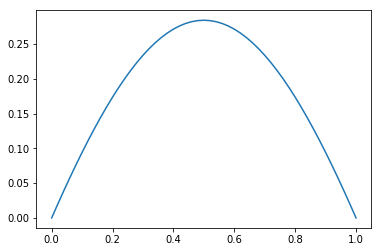

In [106]:
plt.plot(x, np.exp(-x**2+x)-1)